In [1]:
import pandas as pd
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns', None)

# Retention
Написать функцию, которая будет считать Retention игроков (по дням от даты регистрации игрока).В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [2]:
#Загружаем датасеты
reg_ts = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-krasheninnikov/shared/problem1-reg_data.csv', sep=';')
auth_ts = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-krasheninnikov/shared/problem1-auth_data.csv', sep=';')

In [3]:
#Мерджим датасеты между собой, и переводим время в формат datetime
df = reg_ts.merge(auth_ts, on='uid')
df.reg_ts = pd.to_datetime(df.reg_ts, unit='s')
df.auth_ts = pd.to_datetime(df.auth_ts, unit='s')

In [4]:
df.head()

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


In [5]:
#Смотрим за какое время предоставлены данные
print(f'Первая дата регистрации:{df.reg_ts.min()}\nПоследняя дата регистрации:{df.reg_ts.max()}\nПервая дата захода:{df.auth_ts.min()}\nПоследняя дата захода:{df.auth_ts.max()}')

Первая дата регистрации:1998-11-18 09:43:43
Последняя дата регистрации:2020-09-23 15:17:24
Первая дата захода:1998-11-18 09:43:43
Последняя дата захода:2020-09-23 15:17:24


# Пишем функцию
    На выбор предоставляются 2 функции: 
    
    1) dailyretention(data, first_date, last_date, count_days) - группирует людей по дню регистрации, и считает Retention на основании прошедших дней со дня регистрации. На вход передается 4 переменные: 
           data - датасет в котором будут обязательны 3 колонки(uid- уникальный id пользователя, reg_ts - дата регистрации пользователя(формата datetime), auth_ts - дата захода пользователя(формата datetime)
           first_date - Указывается явно и показывает с какого дня регистрации нам необходимы данные.
           last_date - Указывается явно и показывает до какого дня регистрации нам необходимы данные.
           count_days - Указывается явно и показывает за какой промежуток дней нам будет выводиться показатель Retention
           
    ПРИМЕР ИСПОЛЬЗОВАНИЯ : dailyretention(df, '2020-01-01', '2020-01-15', 20)
    
    2)monthlyretention(data, first_date, last_date, count_month) - группирует людей по месяцу регистрации, и считает Retention на основании прошедших месяцев со дня регистрации. На вход передается 4 переменные: 
           data - датасет в котором будут обязательны 3 колонки(uid- уникальный id пользователя, reg_ts - дата регистрации пользователя(формата datetime), auth_ts - дата захода пользователя(формата datetime)
           first_date - Указывается явно и показывает с какого месяца регистрации нам необходимы данные.
           last_date - Указывается явно и показывает до какого месяца регистрации нам необходимы данные.
           count_month - Указывается явно и показывает за какой промежуток месяцев нам будет выводиться показатель Retention
        
    ПРИМЕР ИСПОЛЬЗОВАНИЯ : monthlyretention(df, '2019-01', '2019-09', 12)
    
    !!! В зависимости от выбранного размера данных, необходимо корректировать размер тепловой карты для нормального отображения:   plt.figure(figsize=(14, 12)) , размеры 14 и 12 указаны в дюймах.

In [6]:
#Первая функция Retention по дням
def dailyretention(data, first_date, last_date, count_days):
    data['day_reg']= data.reg_ts.dt.to_period('D')
    data['day_auth']= data.auth_ts.dt.to_period('D')
    
    cohorts = data.query('@first_date<=day_reg<=@last_date') \
               .groupby(['day_reg', 'day_auth']).agg({'uid': 'nunique'}) \
               .rename(columns={'uid': 'TotalUsers'})
    
    def cohort_period(df):
        df['CohortDays'] = np.arange(len(df)) + 1 
        return df
    cohorts = cohorts.groupby('day_reg').apply(cohort_period)
    
    retantion_count = cohorts.query('CohortDays<=@count_days').reset_index() \
       .pivot(columns='CohortDays', index='day_reg', values='TotalUsers')
    
    sns.set(style='ticks')
    plt.figure(figsize=(14, 12))
    plt.title('Cohorts: User Retention')
    sns.heatmap(retantion_count.div(retantion_count[1], axis=0).T.T, annot=True, fmt='.0%', cmap= 'coolwarm', linewidths=3, cbar= False, linecolor='black')
    
    return retantion_count.div(retantion_count[1], axis=0).round(2)

#Вторая функция Retention по месяцам
def monthlyretention(data, first_date, last_date, count_month):
    data['month_reg']= data.reg_ts.dt.to_period('M')
    data['month_auth']= data.auth_ts.dt.to_period('M')
    
    cohorts = data.query('@first_date<=month_reg<=@last_date') \
               .groupby(['month_reg', 'month_auth']).agg({'uid': 'nunique'}) \
               .rename(columns={'uid': 'TotalUsers'})
    
    def cohort_period(df):
        df['CohortMonth'] = np.arange(len(df)) + 1 
        return df
    cohorts = cohorts.groupby('month_reg').apply(cohort_period)
    
    retantion_count = cohorts.query('CohortMonth<=@count_month').reset_index() \
       .pivot(columns='CohortMonth', index='month_reg', values='TotalUsers')
    
    sns.set(style='ticks')
    plt.figure(figsize=(15, 15))
    plt.title('Cohorts: User Retention')
    sns.heatmap(retantion_count.div(retantion_count[1], axis=0).T.T, annot=True, fmt='.0%', cmap= 'coolwarm', linewidths=3, cbar= False, linecolor='black')
    
    return retantion_count.div(retantion_count[1], axis=0).round(2)

CohortDays,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
day_reg,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.0,0.03,0.05,0.03,0.06,0.06,0.08,0.05,0.04,0.04,0.05,0.07,0.05,0.05,0.05,0.04,0.05,0.04,0.04,0.04
2020-01-02,1.0,0.02,0.05,0.05,0.05,0.06,0.08,0.06,0.06,0.05,0.06,0.06,0.05,0.05,0.04,0.05,0.05,0.05,0.04,0.04
2020-01-03,1.0,0.02,0.03,0.04,0.05,0.07,0.08,0.05,0.05,0.04,0.05,0.06,0.06,0.05,0.05,0.05,0.04,0.04,0.04,0.04
2020-01-04,1.0,0.01,0.04,0.05,0.05,0.06,0.07,0.05,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.04,0.05,0.03,0.05,0.04
2020-01-05,1.0,0.02,0.04,0.05,0.04,0.05,0.08,0.05,0.04,0.05,0.04,0.05,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.03
2020-01-06,1.0,0.03,0.04,0.05,0.04,0.05,0.07,0.06,0.05,0.05,0.05,0.05,0.04,0.04,0.05,0.05,0.04,0.04,0.04,0.03
2020-01-07,1.0,0.02,0.05,0.04,0.06,0.05,0.08,0.05,0.06,0.05,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.04,0.05
2020-01-08,1.0,0.02,0.04,0.04,0.05,0.05,0.08,0.05,0.04,0.06,0.04,0.05,0.05,0.04,0.04,0.04,0.05,0.03,0.04,0.04
2020-01-09,1.0,0.02,0.04,0.05,0.04,0.06,0.07,0.06,0.05,0.05,0.05,0.04,0.05,0.05,0.04,0.04,0.04,0.04,0.05,0.03


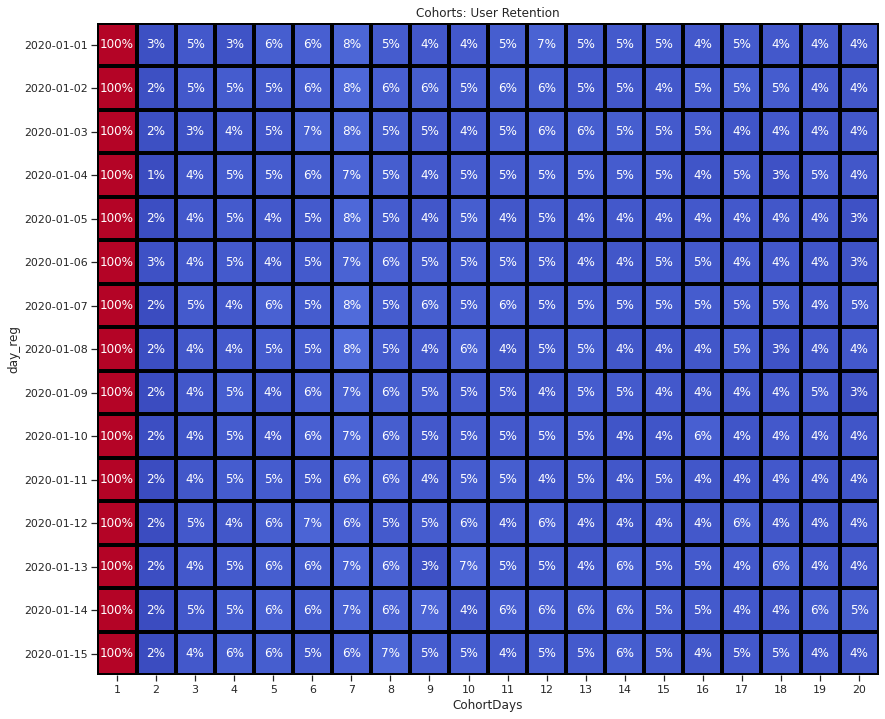

In [8]:
#Выводим дневной Retention пользователей зарегистрировавшихся за промежуток с 1 Января 2020 года до 1 февраля 2020 года за 20 дней
dailyretention(df, '2020-01-01', '2020-01-15', 20)

CohortMonth,1,2,3,4,5,6,7,8,9,10,11,12
month_reg,,,,,,,,,,,,
2019-01,1.0,0.18,0.07,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2019-02,1.0,0.18,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2019-03,1.0,0.17,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2019-04,1.0,0.17,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2019-05,1.0,0.17,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2019-06,1.0,0.18,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2019-07,1.0,0.17,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2019-08,1.0,0.17,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2019-09,1.0,0.17,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


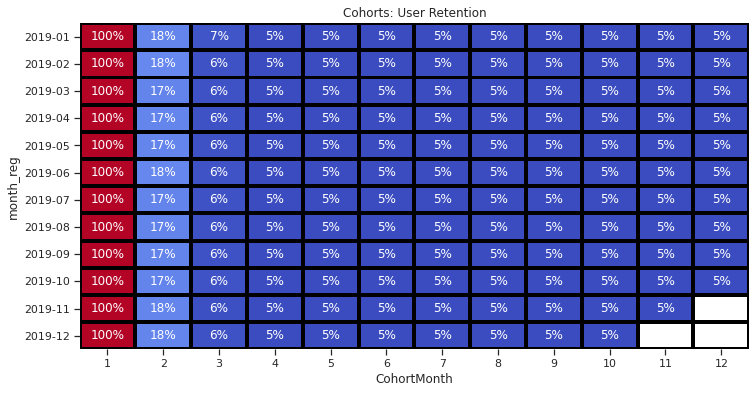

In [14]:
#Выводим месячный Retention пользователей зарегестрировавшихся в 2019 году за 12 месяцев
monthlyretention(df, '2019-01', '2019-12', 12)